In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import spacy
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from xgboost import XGBRegressor

%matplotlib inline

### Read from file

In [2]:
train_data = pd.read_csv('datasets/q2b/train.csv', sep=',')
test_data = pd.read_csv('datasets/q2b/test_without_labels.csv', sep=',')

my_additional_stop_words = ['said','still','day','will','new','may','two','one','now','time','say','second','month','first','going','year','back','people','case','according']

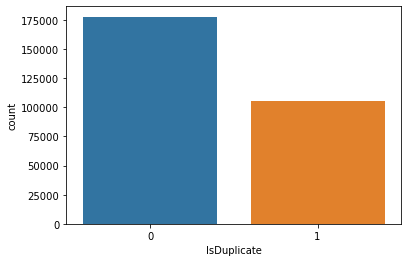

In [3]:
sns.countplot(x='IsDuplicate',data=train_data)

In [3]:
#df_dupl = train_data[train_data['IsDuplicate']==1].head(4000)
#df_nondupl = train_data[train_data['IsDuplicate']==0].head(2500)
#df = pd.concat([df_dupl,df_nondupl])
df = train_data.head(10000)

In [11]:
nltk.download('stopwords')
stopWords = stopwords.words('english')
import re
from gensim.parsing.preprocessing import remove_stopwords
from nltk import ngrams


stopWords.extend(['saying', 'said', 'say', 'yes', 'instead', 'meanwhile', 'right', 'really', 'finally', 'now', 
                       'one', 'suggested', 'says', 'added', 'think', 'know', 'though', 'let', 'going', 'back',
                       'well', 'example', 'us', 'yet', 'perhaps', 'actually', 'oh', 'year', 'lastyear',
                       'last', 'old', 'first', 'good', 'maybe', 'ask', '.', ',', ':', 'take', 'made', 'n\'t', 'go', 
                       'make', 'two', 'got', 'took', 'want', 'much', 'may', 'never', 'second', 'could', 'still', 'get', 
                       '?', 'would', '(', '\'', ')', '``', '/', "''", '%', '#', '!', 'next', "'s", ';', '[', ']', '...',
                       'might', "'m", "'d", 'also', 'something', 'even', 'new', 'lot', 'a', 'thing', 'time', 'way',
                       'always', 'whose', 'need', 'people', 'come', 'become', 'another', 'many', 'must', 'too', 'as', 'well'])

stopWords.extend(['how','where',' ','are','and','I','A','And','So','arnt','this','when','It','many','many','so','cant','Yes','yes','No','no','These','these'])


def processText(text):
    #remove_stopwords(text)
    text = re.sub(r" US ", " usa ", text, flags=re.IGNORECASE)
    text = text.lower()
    text = re.sub("\'s", " ", text)
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub(" what's ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "cannot", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("n't", " not ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub(r" England ", " UK ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]','',text)
    p_stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    stems = [p_stemmer.stem(t) for t in tokens]
    tokens = [wrd for wrd in stems if(wrd not in stopWords)]
    text = ' '.join(tokens)
    #stems = ' '.join(stems)
    tokens = ngrams(text,3)
    return tokens

#X = df['Question1'] + ' q1 q1 q1 '+ df['Question1']+' qqqqq qqqqq qqqqq '+ df['Question2'] + ' q2 q2 q2 ' + df['Question2']
X = df['Question1']+ df['Question1']+' q q q '+ df['Question2'] + df['Question2']
y = df['IsDuplicate']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


vectorizer = TfidfVectorizer(tokenizer=processText,min_df=0,use_idf=True)
X_train_tfidf = vectorizer.fit_transform(X) 
#X_test_vect = vectorizer.transform(X_test) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Method 1 (SVM)

In [5]:
#from sklearn.svm import SVC
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

#determine the model
svc = SVC(kernel='linear',C=1,gamma=0.1)

estimators = [("tf_idf",vectorizer),("svm",svc)]
model = Pipeline(estimators)

kf = KFold(n_splits=5)

accuracy,precision,recall,f1 = 0,0,0,0

for trainI,testI in kf.split(X):
    #kfTestCategIds = le.transform(y[testI])
    model.fit(X[trainI],y[trainI])
    predictions = model.predict(X[testI])
    
    ret = precision_score(y[testI], predictions, average=None)
    precision += float(sum(ret)) / float(len(ret))

    ret = recall_score(y[testI], predictions, average=None)
    recall += float(sum(ret)) / float(len(ret))

    ret = f1_score(y[testI], predictions, average=None)
    f1 += float(sum(ret)) / float(len(ret))

    accuracy += accuracy_score(y[testI], predictions)
    
accuracy,precision,recall,f1 = accuracy/float(5),precision/float(5),recall/float(5),f1/float(5)
print("Accuracy = ",end=' ')
print(accuracy)
print("Precision = ",end=' ')
print(precision)
print("Recall = ",end=' ')
print(recall)
print("f1-score = ",end=' ')
print(f1)

Accuracy =  0.7117
Precision =  0.6916255773759699
Recall =  0.66739735510195
f1-score =  0.6728711397207424


### Method 2 (XGBOOST & Tf Idf)

In [12]:
import xgboost
xg = xgboost.XGBClassifier(gamma=0.1, max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

estimators2 = [("tf_idf",vectorizer),("xgb",xg)]
model2 = Pipeline(estimators2)

kf = KFold(n_splits=5)

accuracy,precision,recall,f1 = 0,0,0,0

for trainI,testI in kf.split(X):
    #kfTestCategIds = le.transform(y[testI])
    model2.fit(X[trainI],y[trainI])
    predictions = model2.predict(X[testI])
    
    ret = precision_score(y[testI], predictions, average=None)
    precision += float(sum(ret)) / float(len(ret))

    ret = recall_score(y[testI], predictions, average=None)
    recall += float(sum(ret)) / float(len(ret))

    ret = f1_score(y[testI], predictions, average=None)
    f1 += float(sum(ret)) / float(len(ret))

    accuracy += accuracy_score(y[testI], predictions)
    
accuracy,precision,recall,f1 = accuracy/float(5),precision/float(5),recall/float(5),f1/float(5)
print("Accuracy = ",end=' ')
print(accuracy)
print("Precision = ",end=' ')
print(precision)
print("Recall = ",end=' ')
print(recall)
print("f1-score = ",end=' ')
print(f1)

Accuracy =  0.7326
Precision =  0.7169496097962064
Recall =  0.6909502800043954
f1-score =  0.6974568587864514


### Predict test set

In [13]:
df_test = test_data['Question1'] + test_data['Question1']+' q q q '+ test_data['Question2'] + test_data['Question2']

In [14]:
df_test = df_test.fillna('null')
pred_final = model2.predict(df_test)

In [15]:
to_print_arr = np.array(test_data[['Id']]).flatten()
columns = pd.Index(['Id','Predicted'])
data = np.column_stack((to_print_arr,pred_final))
df_final = pd.DataFrame(data, index=None, columns = columns)
df_final.to_csv('q2b/duplicate_predictions.csv', sep=',', index=False)

### End of requirement 2b